In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import matplotlib.pyplot as plt
import numpy as np

x_train shape: (50000, 32, 32, 3), y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3), y_test shape: (10000, 1)


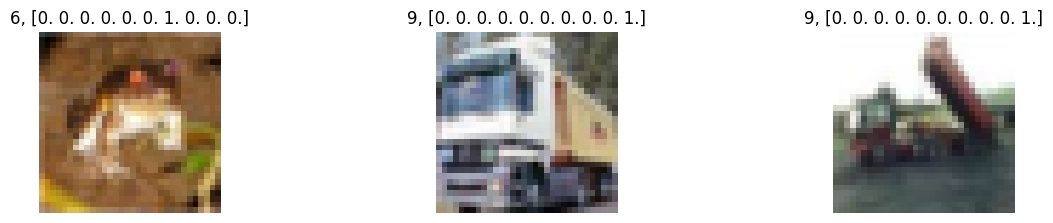

In [3]:
# -------------------------
# 1. Load CIFAR-10 dataset
# -------------------------
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")
x_train_small = x_train[:5000]
y_train_small = y_train[:5000]
x_test_small = x_test[:1000]
y_test_small = y_test[:1000]
x_train = x_train_small
y_train = y_train_small
y_test = y_test_small
x_test = x_test_small
train_images=x_train
train_labels=y_train.flatten()
plt.figure(figsize=(20, 20))
plot_index = 1
num_images = 3  # Number of images to plot

for i in range(num_images):
    plt.subplot(10, 10, plot_index)  # Adjust grid to fit images
    plt.imshow(train_images[i], cmap="gray")
    plt.title(f"{train_labels[i]}, {tf.one_hot(train_labels[i], 10)}")
    plt.axis("off")
    plot_index += 2

plt.tight_layout()
plt.show()

NUM_CLASSES = 10
IMG_SIZE = (224, 224)   # ResNet50 expects 224x224
BATCH_SIZE = 64

# one-hot encode labels
y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

In [4]:
# -------------------------
# 2. Preprocess: resize and normalize using tf.data
# -------------------------
def preprocess(images, labels):
    images = tf.image.resize(images, IMG_SIZE)
    images = preprocess_input(images)  # VGG16 preprocessing
    return images, labels

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(50000).batch(BATCH_SIZE).map(preprocess).prefetch(tf.data.AUTOTUNE)
val_ds   = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE).map(preprocess).prefetch(tf.data.AUTOTUNE)


In [5]:
# -------------------------
# 3. Build model: ResNet50 base + custom head
# -------------------------
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False   # Phase A: freeze all

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,114,826 (91.99 MB)

 Trainable params: 527,114 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [7]:
1e-2

0.01

In [6]:
# -------------------------
# 4. Compile and train head
# -------------------------
model.compile(optimizer=optimizers.Adamax(1e-3),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history_head = model.fit(train_ds, validation_data=val_ds, epochs=5, batch_size=BATCH_SIZE)

Epoch 1/5


79/79 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - accuracy: 0.3964 - loss: 2.0693 - val_accuracy: 0.8160 - val_loss: 0.5778
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.7082 - loss: 0.8592 - val_accuracy: 0.8430 - val_loss: 0.4782
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.7559 - loss: 0.6999 - val_accuracy: 0.8510 - val_loss: 0.4413
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.8008 - loss: 0.5897 - val_accuracy: 0.8600 - val_loss: 0.4064
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.8109 - loss: 0.5700 - val_accuracy: 0.8710 - val_loss: 0.3887


d:\venv\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


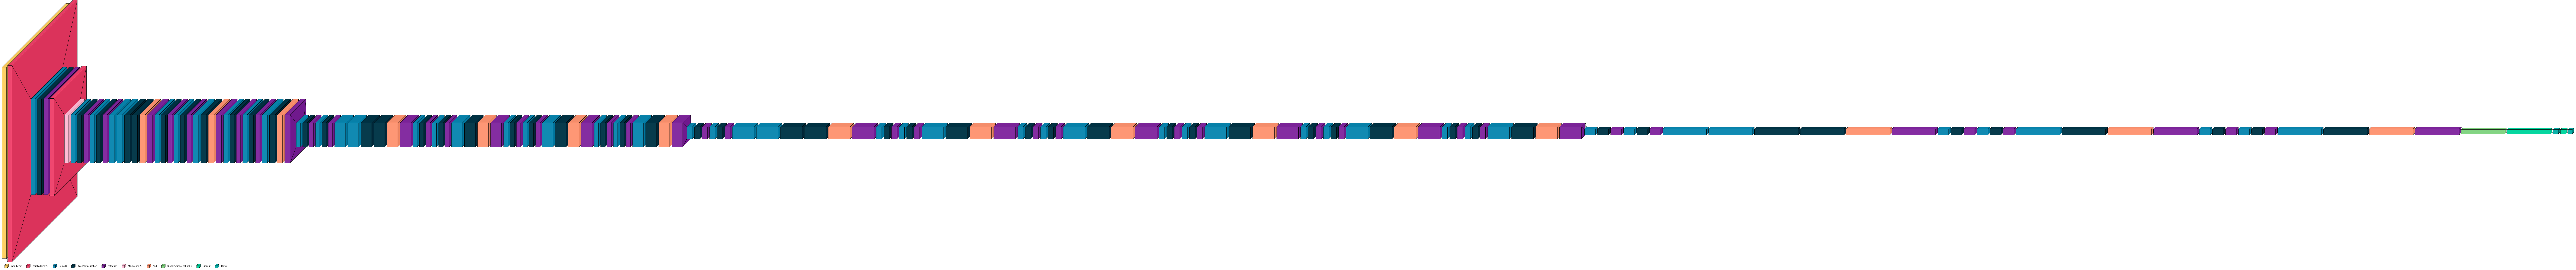

'\n# 2) Keras plot_model (requires graphviz + pydot)\ntry:\n    plot_model(model, to_file="model_graph.png", show_shapes=True, show_layer_names=True)\n    if os.path.exists("model_graph.png"):\n        display(Image("model_graph.png"))\nexcept Exception as e:\n    print("plot_model error (needs graphviz/pydot):", e)\n'

In [7]:
# Visualize the model architecture with visualkeras and tf.keras.utils.plot_model

import visualkeras

from tensorflow.keras.utils import plot_model
from IPython.display import Image, display
import os

# 1) visualkeras layered view (PIL image saved)
try:
    visualkeras.layered_view(model, legend=True, to_file="model_visual.png")
    if os.path.exists("model_visual.png"):
        display(Image("model_visual.png"))
except Exception as e:
    print("visualkeras error:", e)
'''
# 2) Keras plot_model (requires graphviz + pydot)
try:
    plot_model(model, to_file="model_graph.png", show_shapes=True, show_layer_names=True)
    if os.path.exists("model_graph.png"):
        display(Image("model_graph.png"))
except Exception as e:
    print("plot_model error (needs graphviz/pydot):", e)
'''

In [8]:
model.evaluate(val_ds)

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8711 - loss: 0.3907


[0.38866424560546875, 0.8709999918937683]

In [11]:
# Show model config
model.get_config()

{'name': 'functional',
 'trainable': True,
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (None, 224, 224, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_layer'},
   'registered_name': None,
   'name': 'input_layer',
   'inbound_nodes': []},
  {'module': 'keras.layers',
   'class_name': 'ZeroPadding2D',
   'config': {'name': 'conv1_pad',
    'trainable': False,
    'dtype': {'module': 'keras',
     'class_name': 'DTypePolicy',
     'config': {'name': 'float32'},
     'registered_name': None},
    'padding': ((3, 3), (3, 3)),
    'data_format': 'channels_last'},
   'registered_name': None,
   'build_config': {'input_shape': (None, 224, 224, 3)},
   'name': 'conv1_pad',
   'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__',
       'config': {'shape': (None, 224, 224, 3),
        'dtype': 'float32',
        'keras_history': ['input_layer', 0, 0]}},),
     'kwargs': {}}]},
  {'module': 

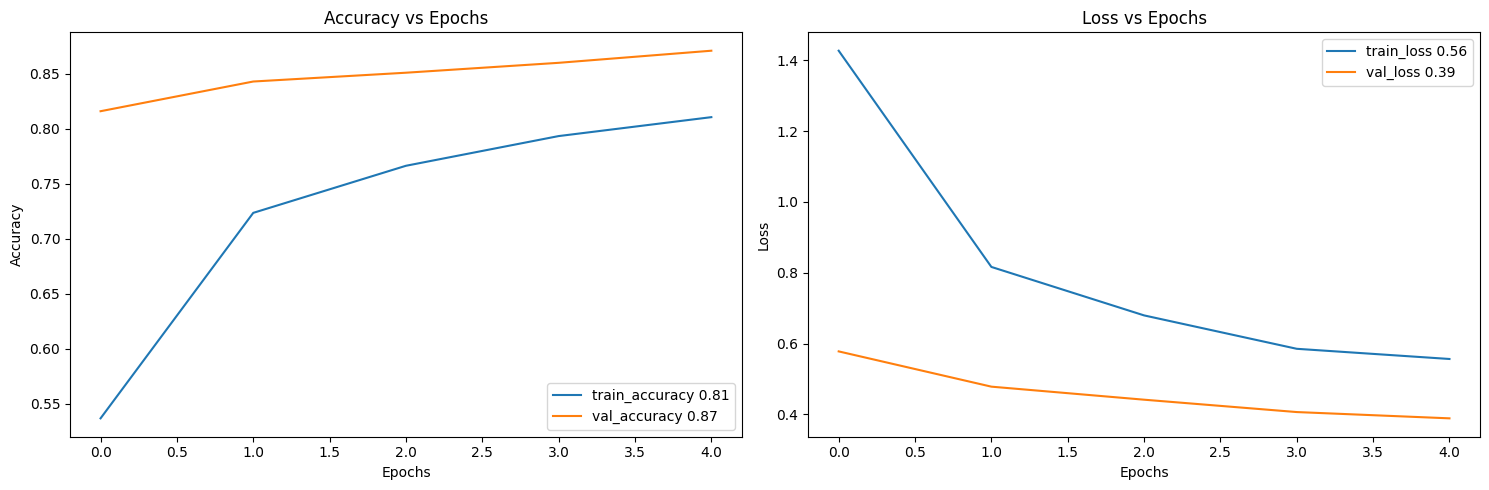

In [10]:
def sub_plot_graph(history, title1, title2):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label=f"train_accuracy {history.history['accuracy'][-1]:.2f}")
    plt.plot(history.history['val_accuracy'], label=f"val_accuracy {history.history['val_accuracy'][-1]:.2f}")
    plt.title(title1)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label=f"train_loss {history.history['loss'][-1]:.2f}")
    plt.plot(history.history['val_loss'], label=f"val_loss {history.history['val_loss'][-1]:.2f}")
    plt.title(title2)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

sub_plot_graph(history_head, "Accuracy vs Epochs", "Loss vs Epochs")

In [19]:
len(model.layers)

180

In [18]:
len(base_model.layers)

175

In [12]:
def unfreeze_slice(index):
    for i, layer in enumerate(base_model.layers[index:]):
        layer.trainable = True
        print(f"Unfrozen: {layer.name} (index {index + i})")

In [14]:
histories = {}

# Freeze all layers first
for layer in base_model.layers:
    layer.trainable = False

# Loop over different numbers of layers to unfreeze
for num_layers_to_unfreeze in range(1, 11):  # unfreeze last 1 to 10 layers
    print(f"\n=== Unfreezing last {num_layers_to_unfreeze} layers ===")

    # Freeze everything again to reset
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze last `num_layers_to_unfreeze` layers
    for i, layer in enumerate(base_model.layers[-num_layers_to_unfreeze:]):
        layer.trainable = True
        print(f"Unfrozen: {layer.name} (index {len(base_model.layers)-num_layers_to_unfreeze+i})")

    # Recompile after changing trainability
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Train
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=5,
        batch_size=BATCH_SIZE,
        verbose=1
    )

    # Store history
    histories[f"unfreeze_{num_layers_to_unfreeze}"] = history

    # Evaluate
    results = model.evaluate(val_ds, verbose=0)
    print(f"Validation loss: {results[0]:.4f}, Validation accuracy: {results[1]:.4f}")

    # Plot curves for this experiment
    sub_plot_graph(
        history,
        f"Accuracy vs Epochs (unfreeze {num_layers_to_unfreeze})",
        f"Loss vs Epochs (unfreeze {num_layers_to_unfreeze})"
    )


=== Unfreezing last 1 layers ===
Unfrozen: conv5_block3_out (index 174)
Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.8204 - loss: 0.5236 - val_accuracy: 0.8690 - val_loss: 0.3823
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - accuracy: 0.8310 - loss: 0.5066 - val_accuracy: 0.8600 - val_loss: 0.3811
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8412 - loss: 0.4894

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Collect results from histories
unfreeze_counts = []
final_val_acc = []
final_val_loss = []

for key, history in histories.items():
    unfreeze_num = int(key.split("_")[1])  
    acc = history.history["val_accuracy"][-1]
    loss = history.history["val_loss"][-1]

    unfreeze_counts.append(unfreeze_num)
    final_val_acc.append(acc)
    final_val_loss.append(loss)

# Sort results by number of unfrozen layers
order = np.argsort(unfreeze_counts)
unfreeze_counts = np.array(unfreeze_counts)[order]
final_val_acc = np.array(final_val_acc)[order]
final_val_loss = np.array(final_val_loss)[order]

# --- 1. Side-by-side Bar Charts (Accuracy & Loss) ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(unfreeze_counts, final_val_acc, color="skyblue")
axes[0].set_xlabel("Unfrozen Layers")
axes[0].set_ylabel("Validation Accuracy")
axes[0].set_title("Effect of Unfreezing on Accuracy")
axes[0].set_xticks(unfreeze_counts)

axes[1].bar(unfreeze_counts, final_val_loss, color="salmon")
axes[1].set_xlabel("Unfrozen Layers")
axes[1].set_ylabel("Validation Loss")
axes[1].set_title("Effect of Unfreezing on Loss")
axes[1].set_xticks(unfreeze_counts)

plt.tight_layout()
plt.show()

# --- 2. Dual-axis Line Plot (Accuracy + Loss vs Layers) ---
fig, ax1 = plt.subplots(figsize=(8,5))

color = "tab:blue"
ax1.set_xlabel("Unfrozen Layers")
ax1.set_ylabel("Validation Accuracy", color=color)
ax1.plot(unfreeze_counts, final_val_acc, marker="o", color=color, label="Val Accuracy")
ax1.tick_params(axis="y", labelcolor=color)

ax2 = ax1.twinx()
color = "tab:red"
ax2.set_ylabel("Validation Loss", color=color)
ax2.plot(unfreeze_counts, final_val_loss, marker="s", color=color, label="Val Loss")
ax2.tick_params(axis="y", labelcolor=color)

plt.title("Effect of Unfreezing Layers on Accuracy & Loss")
fig.tight_layout()
plt.show()

# --- 3. Scatter Plot (Accuracy vs Loss Trade-off) ---
plt.figure(figsize=(7,6))
plt.scatter(final_val_loss, final_val_acc, c=unfreeze_counts, cmap="viridis", s=100)
for i, txt in enumerate(unfreeze_counts):
    plt.annotate(txt, (final_val_loss[i], final_val_acc[i]), textcoords="offset points", xytext=(5,5))
plt.xlabel("Validation Loss")
plt.ylabel("Validation Accuracy")
plt.title("Accuracy vs Loss Across Unfreeze Steps")
plt.colorbar(label="Unfrozen Layers")
plt.show()


In [ ]:
# -------------------------
# 5. Progressive unfreezing (block by block)
# -------------------------
'''def unfreeze_block(block_num):
    for layer in base_model.layers:
        if f'block{block_num}_' in layer.name:
            layer.trainable = True

blocks_to_unfreeze = [5, 4]  # you can add 3, 2, 1 for deeper fine-tuning
fine_tune_histories = []

for block in blocks_to_unfreeze:
    print(f"\n--- Unfreezing block {block} ---")
    unfreeze_block(block)
    model.compile(optimizer=optimizers.Adam(1e-5),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    hist = model.fit(train_ds, validation_data=val_ds, epochs=3)
    fine_tune_histories.append(hist)'''
    
# -------------------------
# Unfreeze a slice of layers
# -------------------------
'''def unfreeze_slice(start=None, end=None):
    """
    Unfreezes layers[start:end] (Python slicing rules).
    Example:
        unfreeze_slice(4, None)   # unfreeze from layer 4 to the end
        unfreeze_slice(None, 4)   # unfreeze first 4 layers
    """
    for i, layer in enumerate(base_model.layers[start:end]):
        layer.trainable = True
        #layer.trainable = False
        print(f"Unfrozen: {layer.name} (index {i})")

unfreeze_slice(15,None)'''